# <font style="color:blue">Train a Custom Object Detector using DarkNet YOLOv3</font>
In this notebook, we will learn how train a object detector for an object of our choice. We will use DarkNet framework and YOLO v3 architecture.

We will use images of Ambulance from Open Images Dataset.

# <font style="color:blue">Change Runtime Type</font>
Before proceeding, make sure that the notebook is running on the GPU. Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

# <font style="color:blue">1. Link Google Drive [ Optional ]</font>
Since it will take considerable amount of time to train the network, it is a good idea to link your Google Drive with Colab so that everything is backed up. So, if the runtime gets disconnected in the middle of something, you can simply re-link the drive and start working. To link drive, just run the cell below and follow the 2 steps.

1. It will generate a link. Click on the link to login to your google account
1. Get the authorization code and paste it in the box under the cell.

You may however choose to do everything without linking google drive and everything will work as usual.

### <font style="color:green">Uncomment the 2 cells below to link google drive</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/MaskDataSet

/content/drive/My Drive/MaskDataSet


In [3]:
!ls

backup	     darknet		data_train.txt	mask_no-mask_dataset  yolo_mask-test.cfg
bad.list     darknet53.conv.74	image2.jpg	train_log.txt	      yolo_mask-train.cfg
class.names  data_test.txt	img.jpg		yolo_mask-setup.data


# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.39 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (10666/10666), done.
Updating files: 100% (2056/2056), done.


# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [4]:
%cd darknet

/content/drive/My Drive/MaskDataSet/darknet


In [5]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


In [6]:
%cd ../
!ls

/content/drive/MyDrive/MaskDataSet
backup	     darknet		data_train.txt	mask_no-mask_dataset  yolo_mask-test.cfg
bad.list     darknet53.conv.74	image2.jpg	train_log.txt	      yolo_mask-train.cfg
class.names  data_test.txt	img.jpg		yolo_mask-setup.data


In [ ]:
import random
import os
import subprocess
import sys

image_dir = "./mask_no-mask_dataset/"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1

        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

You can see there are 4 files which have been downloaded. We will go through each file in the next section.

# <font style="color:blue">6. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone.

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [ ]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2024-04-12 12:57:11--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2024-04-12 12:57:12--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d92184e78937693cd6a1fbc68.dl.dropboxusercontent.com/cd/0/get/CQ7oSyz1Tb0Cg4IuMYK6bSuSv1_pCMI_PQpRU2vVI_KTvPqrhIGZfOKJaS1jXV4nzTkr7hUQ7YhBwQmvfiiGKuO0AscvvchSosCkVYLEpOyyM1k1XTJxGm4PUo-hW58WgUfAkTITHDx1G9PdFAQZyUEU/file?dl=1# [following]
--2024-04-12 12:57:12--  https://uc1d92184e78937693cd6a1fbc68.dl.dropboxusercontent.com/cd/0/get/CQ7oSyz1Tb0Cg4IuMYK6bSuSv1_pCMI_PQpRU2vVI_KTvPqrhIGZfOKJaS1jXV4nzTkr7hUQ7YhBwQmvfiiGK

In [ ]:
%mkdir backup
!ls

backup	darknet  darknet53.conv.74  data_test.txt  data_train.txt  mask_no-mask_dataset


# <font style="color:blue">8. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file,
1. path to config file,
1. path to convolutional weights file

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [ ]:
%cd MaskDataSet/
!ls

/content/drive/MyDrive/MaskDataSet
backup	     darknet		data_train.txt	      yolo_mask-setup.data
bad.list     darknet53.conv.74	mask_no-mask_dataset  yolo_mask-test.cfg
class.names  data_test.txt	train_log.txt	      yolo_mask-train.cfg


In [ ]:
!ls /usr/local/cuda/lib64 | grep cudnn

In [ ]:
!./darknet/darknet detector train yolo_mask-setup.data yolo_mask-train.cfg /content/drive/MyDrive/MaskDataSet/backup/yolo_mask-train_2000.weights

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.057865, iou_loss = 0.000000, total_loss = 0.057865 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.790321), count: 4, class_loss = 0.419356, iou_loss = 0.208184, total_loss = 0.627539 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.636023), count: 4, class_loss = 1.671303, iou_loss = 1.488033, total_loss = 3.159335 
 total_bbox = 94753, rewritten_bbox = 0.011609 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.556455), count: 1, class_loss = 0.080596, iou_loss = 0.278387, total_loss = 0.358983 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.770616), count: 3, class_loss = 0.058582, iou_loss = 0.165156, total_loss = 0.223738 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00

Due to collab GPU limitations , could complete training only till 2000 iterations.

# <font style="color:blue">Notes on Training</font>
From the above training process we can make the following observations:
1. The images are resized after every 10 iterations
It takes around 11 seconds per iteration which consists of 64 images for an image size of 576.
1. We can see that the training started very slowly in the first few iterations and then very gradually, the loss started reducing.
1. As we can see the learning rate increases gradually from 0 to 0.001 by the 100th batch ( burn_in was set to 100 ). It would stay there till the 1500th batch when it would again change to 0.0001.
1. mAP is calculated for every 100 iterations. It reaches >80% after 200 iterations.
1. You can check out the training graph for mAP v/s iterations which is saved in the file **chart.png**

# <font style="color:blue">9. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("img.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">9.3. Test Image 3</font>

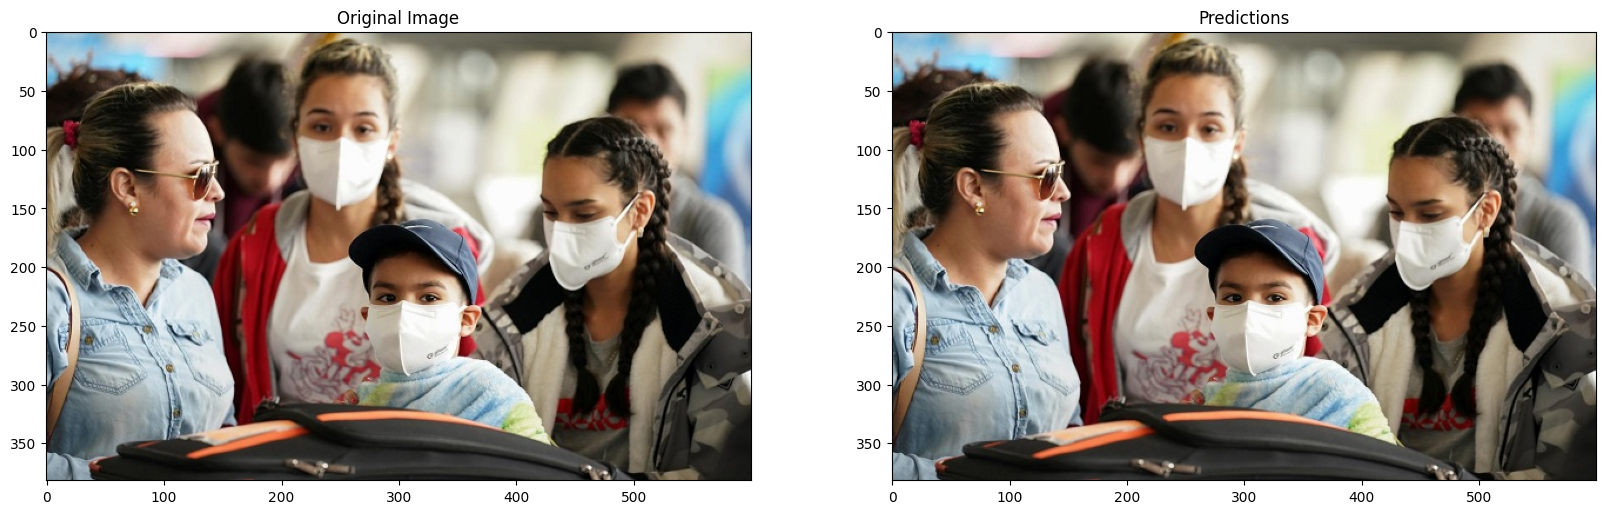

In [ ]:
!./darknet detector test yolo_mask-setup.data yolo_mask-test.cfg /content/drive/MyDrive/MaskDataSet/backup/yolo_mask-train_2000.weights img.jpg -thresh .6 2> /dev/null
display_output("img.jpg")

### <font style="color:green">9.4. Test Image 4</font>

In [ ]:
!./darknet detector test yolo_mask-setup.data yolo_mask-test.cfg backup/yolo_mask-train_best.weights image2.jpg -thresh .6 2> /dev/null
display_output("image2.jpg")